# Project 2: Span Identification with Sequence Labeling Models
## CS4740/5740 Fall 2020

### Project Submission Due: Oct 23rd
Please submit **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to project 1 instructions.



Names:

Netids:

Don't forget to share your newly copied notebook with your partner!


**Reminder: both of you can't work in this notebook at the same time from different computers/browser windows because of sync issues. We even suggest to close the tab with this notebook when you are not working on it so your partner doesn't get sync issues.**


### Q0: Individual Member Contribution

Briefly explain the contribution of individual group members here. Report if working loads are unfairly distributed.

# Overview

---

In this project, you will implement a model that identifies relevant information in a text and tags it with the appropriate label. Particularly, the task of this project is **Propaganda Identification**. The given dataset contains (manual) annotations indicating fragments of text that exhibit one of a set of well-known [propaganda techniques](https://propaganda.qcri.org/annotations/definitions.html). Your task is to develop NLP models to identify these propagandistic spans of text automatically. We will treat this as a **sequence-tagging task**: for each token in the input text, assign a label $y\in\{0,1\}$, such that *1 represents propagandistic text* and *0 represents non-propaganda*.   (A description of the original task formulation is [here](https://propaganda.qcri.org/ptc/).  We are working on a modified version of their "span identification" task.)

For this project, you will implement two sequence labeling approaches:

- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM), which is an adaptation of an HMM in which a Logistic Regression classifier (also known as a MaxEnt classifier) is used to obtain the lexical generation probabilities (i.e., the observation/emission probability matrix, so "observations" == "emissions" == "lexical generations").  Feature engineering is strongly suggested. (Papers from the [Workshops on Figurative Language Processing](https://sites.google.com/view/figlang2020/) can provide good insights on feature selection for this task.) You can also refer to the J&M book. 

Implementation of the Viterbi algorithm (for finding the most likely tag sequence to assign to an input text) is required for both parts, so make sure that you understand it ASAP.

You will implement and train two sequence tagging models, generate your predictions for the provided test set, and submit them to **Kaggle**. Please enter all code and answer the questions of this colab notebook.

**Jurafsky & Martin reading on HMMs and MEMMs can be found in Ch. 8.3–8.5.** The code you write can be added anywhere in the document, but we implore you to keep it readable. You will be asked to describe and motivate your models in parts of the document. You will be graded on both the code and text you write; see grading details at the end of the document.


# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Grading breakdown is found at the end; please consult it.
3. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.
4. The project is somewhat open ended. ("But that's a good thing.  Really. It's more fun that way", says Claire and Esin.) We will ask you to implement some model, but precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using our tokenization code.  As a result, **it is probably easiest if you use our tokenization code for the entire project**.
5. You will be asked to fill in your code at various points of the document. You will also be asked to answer questions that analyze your results and motivate your implementation. These questions are named Q1-Q8. You may create additional cells to insert code, text and images as necessary.
6. Kaggle is not able to calculate *span-level* P/R/F1 measures, which is the standard way to evaluate this type of sequence-tagging task. And we don't actually care so much about the token-level tagging accuracy, which Kaggle **can** calculate.  In particular, there are many fewer propaganda tokens than non-propaganda ones, so always guessing "non-propaganda" would produce a very high accuracy.  So we are compromising by using token-level **weighted accuracy**.  Here is how it works:

A **weighted accuracy** metric that favors finding propagandistic tokens over non-propagandistic ones. The weights for both classes are the inverse of their frequencies.  

``` 
frac_propaganda = num_propaganda/num_labels   [in the answer key]
weight_propaganda = 1/frac_propaganda  
weight_non_propaganda = 1/(1-frac_propaganda)

weighted_accuracy = 
   ((weight_propaganda * # propaganda correct) 
                      +
   (weight_non_propaganda * # non_propaganda correct)) / 
   
   ((weight_propaganda * num_propaganda) 
                      +
   (weight_non_propaganda * num_non_propaganda))
```  
This is also known as the **macro average**, i.e., the average of the accuracy for each label type.


# Task and dataset

---

1. Obtain the data from Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38.
2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)



train_path = os.path.join(os.getcwd(), "drive", "My Drive", "p2", "train", "train") # replace based on your Google drive organization
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "p2", "test", "test") # replace based on your Google drive organization
print(os.listdir(train_path)[:5])
print(os.listdir(test_path)[:5])

Mounted at /content/drive
['article762340819.txt', 'article696735702.txt', 'article766084411.task-si.labels', 'article728680557.txt', 'article764518567.task-si.labels']
['article698092698.txt', 'article699142854.txt', 'article111111121.txt', 'article701939679.txt', 'article706636401.txt']


3. The *train* directory contains *article{XXX}.txt* files which are plaintext documents and also *label* files such as *article{XXX}.task-si.labels*. These label files correspond to the byte-span offests of each segment of propaganda in the associated article. (The tokenizer that we describe just below converts the byte-span representation of propagandistic text spans  into the token-level gold-standard labels that your sequence-tagging models require for training.) The test directory *only* contains articles; you will use your models to detect the propagandistic spans within them.  

4. We provide a tokenizer for these documents. You **must** use this tokenizer as the labels that Kaggle expects are based upon this tokenization. The code below tokenizes each document and generates the appropriate token-level labels consistent with the associated *labels* file. (This is so that you do not need to perform any byte-level text processing.  In particular, the tokenizer  merges nested or overlapping propagandistic text spans from the article into a single segment. You really shouldn't have to look at the *lables* files at all.) The code uses python type annotations; these indicate the type of arguments the functions take.

5. Documents are represented as a list of strings, each being a token. Labels are represented as a list of integers in {0,1}, 1 corresponding to a propagandistic token and 0 to not propaganda.



In [ ]:
import os
from typing import List, Tuple

from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

def read_txt(fname):
  with open(fname) as open_article:
    lines = open_article.read()
  return lines

def read_labels(labels : str) -> List[Tuple[int, int]]:
	"processing of labels file"
	labels = labels.split("\n")[:-1]
	labels = [tuple(map(int, l.split("\t")[1:])) for l in labels]
	return labels

def sort_and_merge_labels(labels : List[Tuple[int, int]]) -> List[Tuple[int, int]]:
  "sort labels, necessary for later splitting"
  if len(labels) == 0:
    return labels
  labels = list(sorted(labels, key = lambda t: t[0]))
  # merge
  curr = labels[0]
  merged = []
  for l in labels[1:]:
      # if distinct, add
      if l[0] > curr[1]:
        merged.append(curr)
        curr = l
      # else merge
      else:
        curr = (curr[0], max(curr[1], l[1]))
  merged.append(curr)
  return merged

def split_with_labels(labels : List[Tuple[int, int]], article : str) -> Tuple[List[str], List[int]]:
  "split text into segments based upon labels"
  if len(labels) == 0:
    return [article], [0]
  segments = []
  binary_class = []
  start = 0
  for l_start, l_end in labels:
    std_seg = article[start:l_start]
    prop_seg = article[l_start:l_end]
    segments.append(std_seg)
    binary_class.append(0)
    segments.append(prop_seg)
    binary_class.append(1)
    start = l_end
  last_seg = article[start:]
  segments.append(last_seg)
  binary_class.append(0)
  return segments, binary_class

def remove_newline_fix_punc_seg(segments):
  " preprocessing necessry for tokenization to be consistent"
  segments = [s.replace("\n", " ").replace(".", " .") for s in segments]
  return segments

def remove_newline_fix_punc_art(article):
  " preprocessing necessry for tokenization to be consistent"
  article = article.replace("\n", " ").replace(".", " .")
  return article

def get_toks(input):
  output = []
  for toks in [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(input)]:
    output += toks
  return output

# This is the function you may need to call
def tokenize_article(article_file):
  "calls all functions above and perform sanity checks"
  article = read_txt(article_file)
  article = remove_newline_fix_punc_art(article)
  art_toks = get_toks(article)
  return art_toks

# This is the function you may need to call
def master_tokenizer(article_file, labels_file):
  "calls all functions above and perform sanity checks"
	# read and get labels
  article = read_txt(article_file)
  labels = read_txt(labels_file)
  labels = read_labels(labels)
  labels = sort_and_merge_labels(labels)
  segments, binary_class = split_with_labels(labels, article)
  article = remove_newline_fix_punc_art(article)
  segments = remove_newline_fix_punc_seg(segments)
  # sanity check
  reconstructed = ""
  for seg, lab in zip(segments, binary_class):
    reconstructed += seg
  assert reconstructed == article
	# tokenize
  seg_toks = []
  new_labels = []
  for seg, label in zip(segments, binary_class):
    new_toks = get_toks(seg)
    seg_toks += new_toks
    new_labels += [label for _ in range(len(new_toks))]
	# sanity check
  art_toks = get_toks(article)
  sanity = True
  if len(art_toks) != len(seg_toks):
    sanity = False
  for i, (at, st, lab) in enumerate(zip(art_toks, seg_toks, new_labels)):
    if at != st:
      sanity = False
      break
  return seg_toks, new_labels, sanity




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 6. Execute the commands below to visualize the tokenization:

In [ ]:
article_file = "article698018235.txt"
#article_file = os.listdir(train_path)[0]
labels_file = "article698018235.task-si.labels"
article_file = os.path.join(train_path, article_file)
labels_file = os.path.join(train_path, labels_file)
tokens, labels, _ = master_tokenizer(article_file, labels_file)

print(len(tokens), len(labels), tokens[:10])


700 700 ['dan', 'fishback', ':', 'it', "'s", 'okay', 'to', 'boycott', 'israeli', 'plays']


7.  Provide some quantitative data exploration. Assess dataset size, documents lengths and class inbalance. Give some examples of sentences containing propaganda techniques.

In [ ]:
tokens_list=[[]]*260
labels_list=[[]]*260

In [ ]:
# code here
j = 0
for i in range(0,len(os.listdir(train_path))):
  if (os.listdir(train_path)[i][-1]=='s'):
    continue;
  else:
    article_file = os.listdir(train_path)[i]
    labels_file = os.path.basename(os.listdir(train_path)[i])[:-3]+'task-si.labels'
    article_file = os.path.join(train_path, article_file)
    labels_file = os.path.join(train_path, labels_file)
    tokens, labels, _ = master_tokenizer(article_file, labels_file)

    tokens_list[j] = tokens
    labels_list[j] = labels
    j = j + 1
  

  def put_together(col):
    ls=[]
    for i in range(len(col)):
      for item in col[i]:
        ls.append(item)
    return ls

  list_token = put_together(tokens_list)
  list_label = put_together(labels_list)


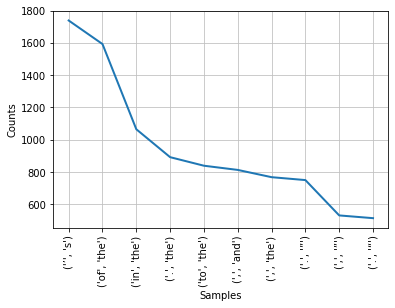

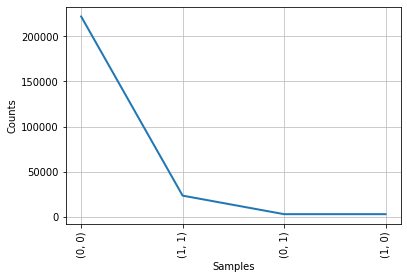

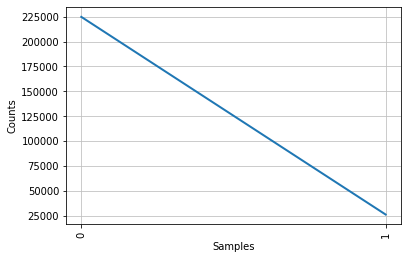

In [ ]:
token_dist = nltk.FreqDist(nltk.bigrams(list_token)) 
token_dist.plot(10,cumulative=False)
label_dist = nltk.FreqDist(nltk.bigrams(list_label))
label_dist.plot(10,cumulative=False)
label_dict = nltk.FreqDist(list_label)
label_dict.plot(10,cumulative=False)

### Q1: Initial data observations
What are your initial observations of the dataset after you explore the dataset?

**Answer:**

# Model 1: HMM Implementation

---

In this section, you will implement a HMM model for this task. We expect:


1. An implementation of the **Viterbi algorithm** that can be used to infer token-level labels --- propaganda or not propaganda --- for an input document.   This process is commonly referred to as **decoding**.
2. Code for counting and smoothing of labels and words as necessary to support the HMM decoding. (This is pretty much what you already know how to do from project 1.)


The tokenization of documents can be performed with the code we provide above. We suggest you calculate probabilities in a log form.  Bigram Viterbi is $ \mathcal{O}(sm^2)$ where s is the length of the sentence and m is the number of tags. Your implementation should have similar efficiency.

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programmes to detect plagiarism.

In [ ]:
import pandas as pd
import numpy as np
matrix1 = pd.DataFrame(list_label,columns=['label'])
matrix1 = pd.concat([matrix1, pd.DataFrame(list_token,columns=['token'])],axis=1)








In [ ]:
token_dist = nltk.FreqDist(nltk.bigrams(list_token)) 
label_dist = nltk.FreqDist(nltk.bigrams(list_label))
label_dict = nltk.FreqDist(list_label)
token_u = nltk.FreqDist(list_token)
#len(token_u)
def handle_unk(dist):
  new_dict = dist.copy()
  new_dict['<unk>'] = 0
  res = 0
  for k in list(new_dict.keys()):
    if (new_dict[k] == 1): # convert all freq to 1 to UNK
      new_dict.pop(k)
      res = res + 1
      continue
  #print(res)
  new_dict['<unk>'] = res
  return new_dict
token_u2 = handle_unk(token_u)
#emission_list = set(list_token)
emission_list = set(token_u2)
lkt = pd.DataFrame(emission_list, columns=['token'])
lkt = pd.concat([lkt, pd.DataFrame(np.zeros(len(emission_list)),columns=['label_0'])],axis=1)
lkt = pd.concat([lkt, pd.DataFrame(np.zeros(len(emission_list)),columns=['label_1'])],axis=1)
lkt1 = lkt.copy()
for k in emission_list:
  index1 = lkt1[lkt1['token'] == k].index
  lkt1.iloc[index1, 1] = matrix1[(matrix1['token'] == k)&(matrix1['label'] == 0)].shape[0]
  lkt1.iloc[index1, 2] = matrix1[(matrix1['token'] == k)&(matrix1['label'] == 1)].shape[0]


lkt1

,token,label_0,label_1
0,proclamation,2.0,0.0
1,match,5.0,1.0
2,organizations,15.0,2.0
3,dictator,1.0,2.0
4,agreed,8.0,1.0
...,...,...,...
9404,recitation,2.0,0.0
9405,damage,14.0,6.0
9406,preaching,8.0,1.0
9407,lopez,2.0,0.0


In [ ]:
Tr_p = {}  
Tr_p['0'] = { '0': np.log(label_dist[(0,0)]/len(list_label)), '1':np.log(label_dist[(0,1)]/len(list_label))}  
Tr_p['1'] = { '0': np.log(label_dist[(1,0)]/len(list_label)), '1':np.log(label_dist[(1,1)]/len(list_label))}  
Tr_p   


NameError: ignored

In [ ]:
# Your implementation here
# we expect a function or class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below

  
# emission_matrix





def build_emission_p(obser, k):
  
  # obser  
  obser_vals = obser
  emission_p = {}  
  if obser_vals[0] in emission_list:

     index1 = lkt1[lkt1['token'] == obser_vals[0]].index[0]

     emission_p['0']={obser_vals[0]: np.log((lkt1.iloc[index1, 1]+k)/(label_zero+k*lkt1.shape[0]))}
     emission_p['1']={obser_vals[0]: np.log((lkt1.iloc[index1, 2]+k)/(label_one+k*lkt1.shape[0]))}
  else:
     emission_p['0']= {obser_vals[0]: np.log((k)/(label_zero+k*lkt1.shape[0]))}
     emission_p['1']= {obser_vals[0]: np.log((k)/(label_one+k*lkt1.shape[0]))}
 
  for i in obser_vals[1:len(obser_vals)]:
    
    if i in emission_list:
      
    
      index1 = lkt1[lkt1['token'] == i].index[0]
      emission_p['0'].update({i: np.log((lkt1.iloc[index1, 1]+k)/(label_zero+k*lkt1.shape[0]))}) 
      emission_p['1'].update({i: np.log((lkt1.iloc[index1, 2]+k)/(label_one+k*lkt1.shape[0]))}) 
    else:
      emission_p['0'].update({i: np.log((k)/(label_zero+k*lkt1.shape[0]))}) 
      emission_p['1'].update({i: np.log((k)/(label_one+k*lkt1.shape[0]))}) 
  return emission_p, obser_vals

  
  
def get_max_from_dict(delta) :  
    max_val = -float('inf')  
    max_key = ""  
  
    for key in delta.keys() :  
        
        if delta[key] > max_val :  
            max_key = key   
            max_val = delta[key]  
  
    return max_key, max_val  


def viterbi(ls1,k):
    emiss_probs,obs = build_emission_p(ls1,k)
    len_obs=len(obs)
    V=np.zeros((2,len_obs))
    T=np.zeros((2,len_obs))
    l_tem=np.zeros(len_obs)
    # Initialize base case
    V[0][0]= star['0'] + emiss_probs['0'][obs[0]]
    V[1][0]=star['1']+emiss_probs['1'][obs[0]]
    for i in range(1,len_obs):
        word_i=obs[i]
        a_0=V[0][i-1]+Tr_p['0']['0']
        a_1=V[1][i-1]+Tr_p['1']['0']
        max_p_o= max(a_0,a_1)
        argmax_p_o= np.argmax([a_0, a_1])
        V[0][i]=emiss_probs['0'][word_i] + max_p_o
        T[0][i]=argmax_p_o
        max_p_1=np.max([V[0][i-1]+Tr_p['0']['1'], V[1][i-1]+Tr_p['1']['1']])
        argmax_p_1=np.argmax([V[0][i-1]+Tr_p['0']['1'], V[1][i-1]+Tr_p['1']['1']])
        V[1][i]= emiss_probs['1'][word_i]+max_p_1
        T[1][i]=argmax_p_1
    p=np.max([V[0][len_obs-1],V[1][len_obs-1]])
    which_group=np.argmax([V[0][len_obs-1],V[1][len_obs-1]])
    l_tem[len_obs-1]=which_group
    for j in range(len_obs-1):
        l_tem[len_obs-2-j]=T[which_group][len_obs-1-j]
        which_group=np.int(T[which_group][len_obs-1-j])
    l=[]
    for k in range(len_obs):
        if l_tem[k]==0:
            l.append('0')
        else:
            l.append('1')
    return l

    

viterbi(tokens_list[50],0.01)  
#build_emission_p(tokens_test[8])
#get_max_from_dict({'0': -10.894731564437468, '1': -10.610359866585288})


['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1'

In [ ]:
star = {}  
star['0'] = np.log(label_zero/(label_zero+label_one))
star['1'] = np.log(label_one/(label_zero+label_one))  


In [ ]:
print(tokens_list[50][57:100])
print(labels_list[50][57:100])
viterbi(tokens_list[50][57:59])

['if', 'he', 'can', '’', 't', 'beat', 'them', ',', 'he', '’', 'll', 'join', 'them', '—', 'if', 'not', 'on', 'brexit', ',', 'then', 'in', 'their', 'stance', 'of', 'denial', 'and', 'appeasement', 'regarding', 'the', 'global', 'jihad', 'threat', '.', '’', 'at', 'a', 'recent', 'dinner', 'of', 'the', 'uk', 'independence', 'party']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


['0', '0']

In [ ]:
state = ['Healthy', 'Fever']
 
observations = ['normal', 'cold', 'dizzy']
 
star = {'Healthy': 0.6, 'Fever': 0.4}
 
Tr_p = {
   'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6},
   }
 
emission = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
   }   

def get_max_from_dict(delta) :  
    max_val = -float('inf')  
    max_key = ""  
  
    for key in delta.keys() :  
        
        if delta[key] > max_val :  
            max_key = key   
            max_val = delta[key]  
  
    return max_key, max_val  




Healthy
Fever
['Healthy']
['Healthy', 'Healthy', 'Fever']


## Validation Step

1. Create a validation set from the given dataset, i.e. a subset of (~10%) the training dataset that you only use for evaluating the models, not for training.  (You can think of the validation set as a sample test set.)
2. Train your HMM model on the (remainder of the) training set and evaluate it on the validation set. Report **weighted accuracy**, which is explained in the *Notes* section above.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generaion) probabilities. 

In the *Kaggle Submission* section, there is code provided for generating the output file in the form required for Kaggle.  If you find it useful for computing weighted accuracy, you can use it here as well.

In [ ]:
# Evaluate/validate your model here
# you may attach pictures of graphs etc.
j = 0
for i in range(0,len(os.listdir(train_path))):
  if (os.listdir(train_path)[i][-1]=='s'):
    continue;
  else:
    article_file = os.listdir(train_path)[i]
    labels_file = os.path.basename(os.listdir(train_path)[i])[:-3]+'task-si.labels'
    article_file = os.path.join(train_path, article_file)
    labels_file = os.path.join(train_path, labels_file)
    tokens, labels, _ = master_tokenizer(article_file, labels_file)

    tokens_list[j] = tokens
    labels_list[j] = labels
    j = j + 1
  

  def put_together(col):
    ls=[]
    for i in range(len(col)):
      for item in col[i]:
        ls.append(item)
    return ls



validation_set_token = tokens_list[0:26]
validation_set_label = labels_list[0:26]
training_set_token = tokens_list[27:len(tokens_list)]
training_set_label = labels_list[27:len(tokens_list)]
#validation_set_token[0]
list_token = put_together(training_set_token)
list_label = put_together(training_set_label)




In [ ]:
token_dist = nltk.FreqDist(nltk.bigrams(list_token)) 
label_dist = nltk.FreqDist(nltk.bigrams(list_label))
label_dict = nltk.FreqDist(list_label)
token_u = nltk.FreqDist(list_token)
token_u2 = handle_unk(token_u)
#set(list_token)

print(len(token_u2))
print(len(token_u))
import pandas as pd
import numpy as np
matrix1 = pd.DataFrame(list_label,columns=['label'])
matrix1 = pd.concat([matrix1, pd.DataFrame(list_token,columns=['token'])],axis=1)
print(matrix1.iloc[3,0])



#emission_list = set(list_token)


emission_list = set(token_u)
lkt = pd.DataFrame(emission_list, columns=['token'])
lkt = pd.concat([lkt, pd.DataFrame(np.zeros(len(emission_list)),columns=['label_0'])],axis=1)
lkt = pd.concat([lkt, pd.DataFrame(np.zeros(len(emission_list)),columns=['label_1'])],axis=1)
lkt1 = lkt.copy()
for k in emission_list:
  index1 = lkt1[lkt1['token'] == k].index
  lkt1.iloc[index1, 1] = matrix1[(matrix1['token'] == k)&(matrix1['label'] == 0)].shape[0]
  lkt1.iloc[index1, 2] = matrix1[(matrix1['token'] == k)&(matrix1['label'] == 1)].shape[0]
lkt1

9409
16266
1


,token,label_0,label_1
0,catbird,1.0,0.0
1,baseline,2.0,0.0
2,viner,0.0,1.0
3,caliph,1.0,2.0
4,ex-husband,3.0,0.0
...,...,...,...
16261,bona,2.0,1.0
16262,boy,7.0,3.0
16263,anti-christian,1.0,0.0
16264,arabs,1.0,0.0


In [ ]:
states = ['0', '1']  

label_zero = lkt1['label_0'].sum()
label_one = lkt1['label_1'].sum()

# transition matrix

Tr_p = {}  
Tr_p['0'] = { '0': np.log(label_dist[(0,0)]/label_dict[0]), '1':np.log(label_dist[(0,1)]/label_dict[0])}  
Tr_p['1'] = { '0': np.log(label_dist[(1,0)]/label_dict[1]), '1': np.log(label_dist[(1,1)]/label_dict[1])} 
# π initial prob
star_with_zero = 0
star_with_one = 0

#find all sentence start with '0' & '1'
for i in range(len(tokens_list)):
  if labels_list[i][0] == 1:
    star_with_one = star_with_one + 1
  if labels_list[i][0] == 0:
    star_with_zero = star_with_zero + 1


star = {}  
star['0'] = np.log(label_zero/(label_zero+label_one))
star['1'] = np.log(label_one/(label_zero+label_one))  


In [ ]:
#val_token = put_together(validation_set_token)
val_label = put_together(validation_set_label)
#weight acc

val_pred = []
for i in range(len(validation_set_token)):
  val_pred.append(viterbi(validation_set_token[i],0.01))

val_pred = put_together(val_pred)
prop_dist = nltk.FreqDist(val_pred)

#weight acc
frac_prop = prop_dist['1']/len(val_label)
weight_prop = 1/frac_prop
weight_non_prop = 1/(1-frac_prop)
non_pro_correct = 0
pro_correct = 0
for i in range(len(val_pred)):
  if val_pred[i] == '0':
    if str(val_label[i]) == val_pred[i]:
      non_pro_correct = non_pro_correct + 1
  if val_pred[i] == '1':
    if str(val_label[i]) == val_pred[i]:
      pro_correct = pro_correct + 1
weighted_acc = ((weight_prop *  pro_correct) +(weight_non_prop *  non_pro_correct)) / ((weight_prop * prop_dist['1']) + (weight_non_prop * prop_dist['0']))

#print(weighted_acc)
#report the weighted_accuracy for validation set is 0.58185

NameError: ignored



### Q2 : Explan your HMM implementations

Q2.1: Explain here how you implemented HMMs (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:**

Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your HMM implementation, why?).

**Answer:**



### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:**

Q3.3: What is the effect of unknown word handling and smoothing?

**Answer:**



# Model 2: MEMM Implementation

---


In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same propaganda detection task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 
 
1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such classifier, you need to pick some feature set. The content of the feature set is up to your choice. You should be trying different feature sets, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in *Evaluation* section. 





---
Work flow summary:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)




In [ ]:
# Your model implementation here
# we expect a function of class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below
#
# You will need:
# 1. Extract Features
# 2. Train MaxEnt
# 3. To call Viterbi 

nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer


#extract stemm features
ps = PorterStemmer()

stem_list = []
for w in list_token:
    stem_list.append(ps.stem(w))

#extract position tag features
p_tag = nltk.pos_tag(list_token)
p_tag_list = []

for i in range(len(p_tag)):
  p_tag_list.append(p_tag[i][1])

#extract previous word features
def generate_pre_word_list(ls):
  pre_wl = []
  for i in range(len(ls)):
    if i == 0:
      pre_wl.append('')
    else:
      pre_wl.append(ls[i-1])
  return pre_wl
pre_word_list = generate_pre_word_list(list_token)

#extract previous two word features
def generate_pre_two_word_list(ls):
  pre_wl = []
  for i in range(len(ls)):
    if i == 0 | i == 1:
      pre_wl.append('')
    else:
      pre_wl.append(ls[i-2])
  return pre_wl
pre_two_word_list = generate_pre_two_word_list(list_token)

#extract next word features
def generate_next_word_list(ls):
  nex_wl = []
  for i in range(len(ls)-1):
      nex_wl.append(ls[i+1])
  nex_wl.append('')
  return nex_wl

next_word_list = generate_next_word_list(list_token)

#extract next two word features
def generate_next_two_word_list(ls):
  nex_wl = []
  for i in range(len(ls)-2):
      nex_wl.append(ls[i+2])
  nex_wl.append('')
  nex_wl.append('')
  return nex_wl

next_two_word_list = generate_next_two_word_list(list_token)

#combine all features
#features=[{ 'pos_tag': p_tag_list[g],'stem_w': stem_list[g],'word':list_token[g], 'pre_word': pre_word_list[g],'pre_two_word': pre_two_word_list[g],'next_word':next_word_list[g],'next_two_word':next_two_word_list[g]} for g in range(len(list_token))]
features=[{'pos_tag': p_tag_list[g], 'word':list_token[g],'pre_word': pre_word_list[g],'pre_two_word': pre_two_word_list[g],'next_word':next_word_list[g],'next_two_word':next_two_word_list[g]} for g in range(len(list_token))]
#features=[{'pre_tag':list_label[g-1], 'pos_tag': p_tag_list[g],'word':list_token[g]} for g in range(1,len(list_token))]
train_set = []
for j in range(len(features)):
  train_set.append((features[j],str(list_label[j])))
classifier=nltk.MaxentClassifier.train(train_set,max_iter=20)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.105
             2          -0.20445        0.895
             3          -0.19706        0.895
             4          -0.18946        0.898
             5          -0.18290        0.902
             6          -0.17737        0.906
             7          -0.17269        0.909
             8          -0.16869        0.912
             9          -0.16521        0.915
            10          -0.16216        0.917
            11          -0.15947        0.919
            12          -0.15706        0.921
            13          -0.15489        0.923
            14          -0.15293        0.924
            15          -0.15114        0.92

225856

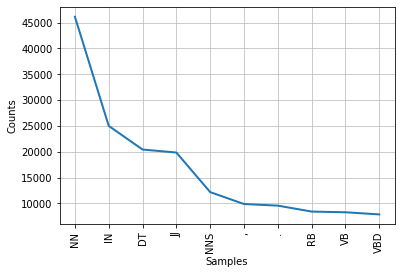

In [ ]:
p_tag_map = nltk.FreqDist(p_tag_list)
p_tag_map.plot(10,cumulative=False)

In [ ]:
from nltk import classify
val_token = put_together(validation_set_token)
#val_label = put_together(validation_set_label)

#extract pos tag for val
p_tag_val = nltk.pos_tag(val_token)
p_tag_list_v = []

for i in range(len(p_tag_val)):
  p_tag_list_v.append(p_tag_val[i][1])

#extract stemm features
ps = PorterStemmer()

stem_list_v = []
for w in val_token:
    stem_list_v.append(ps.stem(w))
#extract previous word feature for val
pre_word_list_v = generate_pre_word_list(val_token)


#extract next word feature for val
next_word_list_v = generate_next_word_list(val_token)

#features=[{'pre_tag':val_label[g-1], 'word':val_token[g]} for g in range(1,len(val_token))]
features = [{'pos_tag': p_tag_list_v[g],'stem_w': stem_list_v[g],'word':val_token[g], 'pre_word': pre_word_list_v[g],'next_word':next_word_list_v[g]} for g in range(len(val_token))]
val_set = [(features[0],str(val_label[0]))]

#build val data calculate un-weight accuracy
for j in range(1,len(features)):
  val_set.append((features[j],str(list_label[j+1])))



In [ ]:
val_pred = []
for i in range(len(validation_set_token)):
   val_pred.append(memm_viterbi(validation_set_token[i]))
val_pred = put_together(val_pred)

In [ ]:
val_label = put_together(validation_set_label)


prop_dist = nltk.FreqDist(val_pred)

#weight acc// same as before
frac_prop = prop_dist['1']/len(val_label)
weight_prop = 1/frac_prop
weight_non_prop = 1/(1-frac_prop)
non_pro_correct = 0
pro_correct = 0
for i in range(len(val_pred)):
  if val_pred[i] == '0':
    if str(val_label[i]) == val_pred[i]:
      non_pro_correct = non_pro_correct + 1
  if val_pred[i] == '1':
    if str(val_label[i]) == val_pred[i]:
      pro_correct = pro_correct + 1
weighted_acc = ((weight_prop *  pro_correct) +(weight_non_prop *  non_pro_correct)) / ((weight_prop * prop_dist['1']) + (weight_non_prop * prop_dist['0']))
print(weighted_acc)

#report the weighted acc for position tags, stem word, pre_word next_word is  0.61
#baseline with all infomative features: report the weighted acc for adding next two word, pre two word acc is 0.643
#report the weighted acc for removing stem word is 0.645
#report the weighted acc for removing pos tag is 0.630
#report the weighted acc for removing next two word is 0.630
#report the weighted acc for removing pre two word is 0.632
#report the weighted acc for removing pre word is 0.636
#report the weighted acc for removing next word is 0.631
#removing multiple features causing model easy to converge, and a lower training acc
def compare_output(pred, real):
  for i in range(len(pred)):
    if pred[i] == '0':
      if str(real[i]) == val_pred[i]:
         non_pro_correct = non_pro_correct + 1
    if val_pred[i] == '1':
      if str(val_label[i]) == val_pred[i]:
         pro_correct = pro_correct + 1

0.6360447289100585


In [ ]:
def from_obs_get_probability_list(ls1):
  #extract previous word feature 
  pre_wl = generate_pre_word_list(ls1)
  #extract previous two word feature for val
  pre_two_wl = generate_pre_two_word_list(ls1)
  #extract next word feature for val
  nex_wl = generate_next_word_list(ls1)
  #extract next word feature for val
  nex_two_wl = generate_next_two_word_list(ls1)
  pos_tag_list=[]
  pos_tag_dict=nltk.pos_tag(ls1)
  for j in range(len(pos_tag_dict)):
    pos_tag_list.append(pos_tag_dict[j][1])
  probability_list=[]
  for i in range(len(ls1)):
    dict_i_list=[]
    dict_i=classifier.prob_classify({'pos_tag': pos_tag_list[i], 'word': ls1[i],'pre_word': pre_wl[i],'pre_two_word':pre_two_wl[i],'next_word':nex_wl[i],'next_two_word':nex_two_wl[i]})
    for label in dict_i.samples():
    
      dict_i_list.append(dict_i.logprob(label))
    dict_i_list.reverse()  
    probability_list.append(dict_i_list)
  return probability_list


def viterbi(ls1,k):
    emiss_probs,obs = build_emission_p(ls1,k)
    Tr_p=from_obs_get_probability_list(ls1)
    obs=ls1
    len_obs=len(obs)
    V=np.zeros((2,len_obs))
    T=np.zeros((2,len_obs))
    l_tem=np.zeros(len_obs)
    # Initialize base case
    V[0][0]= star['0'] + emiss_probs['0'][obs[0]]
    V[1][0]=star['1']+emiss_probs['1'][obs[0]]
    for i in range(1,len_obs):
        word_i=obs[i]
        a_0=V[0][i-1]+Tr_p[i][0]
        a_1=V[1][i-1]+Tr_p[i][0]
        max_p_o= max(a_0,a_1)
        argmax_p_o= np.argmax([a_0, a_1])
        V[0][i]=emiss_probs['0'][word_i] + max_p_o
        T[0][i]=argmax_p_o
        max_p_1=np.max([V[0][i-1]+Tr_p[i][1], V[1][i-1]+Tr_p[i][1]])
        argmax_p_1=np.argmax([V[0][i-1]+Tr_p[i][1], V[1][i-1]+Tr_p[i][1]])
        V[1][i]= emiss_probs['1'][word_i]+max_p_1
        T[1][i]=argmax_p_1
    p=np.max([V[0][len_obs-1],V[1][len_obs-1]])
    which_group=np.argmax([V[0][len_obs-1],V[1][len_obs-1]])
    l_tem[len_obs-1]=which_group
    for j in range(len_obs-1):
        l_tem[len_obs-2-j]=T[which_group][len_obs-1-j]
        which_group=np.int(T[which_group][len_obs-1-j])
    l=[]
    for k in range(len_obs):
        if l_tem[k]==0:
            l.append('0')
        else:
            l.append('1')
    return l

In [ ]:
# actulal implementation of MEMM Vertibi


def from_obs_get_probability_list(ls1):
  #extract previous word feature 
  pre_wl = generate_pre_word_list(ls1)
  #extract previous two word feature for val
  pre_two_wl = generate_pre_two_word_list(ls1)
  #extract next word feature for val
  nex_wl = generate_next_word_list(ls1)
  #extract next word feature for val
  nex_two_wl = generate_next_two_word_list(ls1)
  pos_tag_list=[]
  pos_tag_dict=nltk.pos_tag(ls1)
  for j in range(len(pos_tag_dict)):
    pos_tag_list.append(pos_tag_dict[j][1])
  probability_list=[]
  for i in range(len(ls1)):
    dict_i_list=[]
    dict_i=classifier.prob_classify({'pos_tag': pos_tag_list[i], 'word': ls1[i],'pre_word': pre_wl[i],'pre_two_word':pre_two_wl[i],'next_word':nex_wl[i],'next_two_word':nex_two_wl[i]})
    
    for label in dict_i.samples():
    
      dict_i_list.append(dict_i.logprob(label))
    dict_i_list.reverse()  
    probability_list.append(dict_i_list)
  return probability_list

    
def memm_viterbi(ls1):
    emiss_probs = from_obs_get_probability_list(ls1)
    #print(emiss_probs)
    obs=ls1
    #print(obs)
    len_obs=len(obs)
    V=np.zeros((2,len_obs))
    T=np.zeros((2,len_obs))
    l_tem=np.zeros(len_obs)
    # Initialize base case
    V[0][0]= star['0'] + emiss_probs[0][0]
    V[1][0]=star['1']+emiss_probs[0][1]
    for i in range(1,len_obs):
        word_i=obs[i]
        a_0=V[0][i-1]+Tr_p['0']['0']*0.1
        a_1=V[1][i-1]+Tr_p['1']['0']*0.1
        # a_0=V[0][i-1]+Tr_p['0']['0']
        # a_1=V[1][i-1]+Tr_p['1']['0']
        max_p_o= max(a_0,a_1)
        argmax_p_o= np.argmax([a_0, a_1])
        V[0][i]=emiss_probs[i][0] + max_p_o
        T[0][i]=argmax_p_o
        max_p_1=np.max([V[0][i-1]+Tr_p['0']['1']*0, V[1][i-1]+Tr_p['1']['1']*0])
        argmax_p_1=np.argmax([V[0][i-1]+Tr_p['0']['1']*0, V[1][i-1]+Tr_p['1']['1']*0])
        V[1][i]= emiss_probs[i][1]+max_p_1
        T[1][i]=argmax_p_1
    p=np.max([V[0][len_obs-1],V[1][len_obs-1]])
    which_group=np.argmax([V[0][len_obs-1],V[1][len_obs-1]])
    l_tem[len_obs-1]=which_group
    for j in range(len_obs-1):
        l_tem[len_obs-2-j]=T[which_group][len_obs-1-j]
        which_group=np.int(T[which_group][len_obs-1-j])
    l=[]
    for k in range(len_obs):
        if l_tem[k]==0:
            l.append('0')
        else:
            l.append('1')
    return l




In [ ]:
test_pred = []
for i in range(len(tokens_test)):
   #extract previous word feature for val
  pre_word_list_v = generate_pre_word_list(tokens_test[i])

   #extract next word feature for val
  next_word_list_v = generate_next_word_list(tokens_test[i])
  pos_tag_list_v = nltk.pos_tag(tokens_test[i])
  for j in range(len(tokens_test[i])):
  
      #val_pred.append(classifier.classify({'pre_tag': 0, 'word': validation_set_token[i][j]}))
    test_pred.append(classifier.classify({'pos_tag': pos_tag_list_v[j], 'stem_w': ps.stem(tokens_test[i][j]),'word': tokens_test[i][j], 'pre_word': pre_word_list_v[j],'next_word':next_word_list_v[j]}))


test_pred = put_together(test_pred)
print(len(test_pred))

51214


In [ ]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)



#extract pos tag for test
#p_tag_test = [[]] * 47
#p_tag_list_test = []
#for j in range(len(tokens_test)):

  #p_tag_test[j] = nltk.pos_tag(tokens_test[j])
  #print(p_tag_test[0][1])

#for j in range(len(p_tag_test)):
  #for item in p_tag_test[j]:
    #p_tag_list_test.append(item[1])


output = []
for i in range(len(tokens_test)):
  print(i)
  output.append(memm_viterbi(tokens_test[i]))


output = put_together(output)     




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [ ]:
classifier.show_most_informative_features(50)
classifier.weights().shape[0]

   8.133 pre_two_word=='plutocratic' and label is '1'
   7.498 next_word=='corridors' and label is '1'
   7.252 next_word=='invading' and label is '1'
   7.157 next_two_word=='misspelling' and label is '1'
   7.020 next_two_word=='kendra' and label is '1'
   6.961 pre_two_word=='nurture' and label is '1'
   6.792 pre_word=='tellingly' and label is '1'
   6.723 next_word=='.he' and label is '1'
   6.639 next_word=='clarifies' and label is '1'
   6.532 next_word=='wizard' and label is '1'
   6.439 word=='wizard' and label is '1'
   6.423 pre_word=='edict' and label is '1'
   6.331 next_two_word=='clarifies' and label is '1'
   6.330 word=='battens' and label is '1'
   6.242 pre_word=='sewer' and label is '1'
   6.218 pre_two_word=='trashing' and label is '1'
   6.193 pre_two_word=='harking' and label is '1'
   6.145 word=='hay' and label is '1'
   6.107 word=='shadows' and label is '1'
   6.077 next_two_word=='exaggerate' and label is '1'
   6.057 pre_two_word=='analyst' and label is '1'

101045

### Q4: Implementation Details

Q4.1: Explain here how you implemented the MEMM (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**

Q4.2: What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets.

**Answer:**



### Q5: Results Analysis

Q5.1: Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

Q5.2: An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why? 

**Answer:**

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:**




#Comparing HMMs and MEMMs

---


### Q6:


Compare here your results for your HMM and the MEMM. Which of them performs better? 

**Answer:**


###Q7: Error Analysis
Q7.1: Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not?

**Answer:** label bias in memm is a big problem. In hmm, a label 0 can have multiple choice for its next step ('0','1'), but in memm, if the pre tag is ('0') and the model learn ('0') better, it is less likely to pay attention to label ('1'). Memm can only get local optim but not global optim.

Q7.2: What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe?

**Answer:**
MEMM suffer from the "label bias problem," where states with low-entropy transition distributions "effectively ignore their observations." 
Another source of label bias is that training is always done with respect to known previous tags, so the model struggles at test time when there is uncertainty in the previous tag.



# Kaggle Submission 
---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38. Note, you **need** to use our tokenizer as the labels on Kaggle corresponds to these. Below, we provide a script that submits a random guess/all ones or all zeroes in the correct format. Note that you only need to provide a function which takes as input a sequence of tokens, and outputs a sequence of labels (in the form of integers  in {0,1}, 1 corresponding to propaganda). As a scoring metric on Kaggle, we use **weighted accuracy**, described in the *Notes* section towards the beginning of the notebook.


In [ ]:
import random
from typing import Callable


def submission_to_csv(binary_class : List[List[int]], fname : str):
  # writes submission to CSV
  new_binary = []
  for classes in binary_class:
    new_binary += classes
  with open(fname, 'w') as file:
    file.write('id,category\n')
    for i, line in enumerate(new_binary):
      file.write('{},{}\n'.format(i,line))


def random_predictor(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(random.randint(0,1))
  return output

def always_one(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(1)
  return output

def always_zero(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(0)
  return output


def generate_submission(predictor: Callable[[List[str]], List[int]], fname : str, test_path : str):
  # generate a submission with random guesses
  sample_submission = []
  articles = os.listdir(test_path)
  total, fail, targets, test_articles = 0,0, [], []
  for article in sorted(articles):
    article_file = os.path.join(test_path, article)
    art_toks = tokenize_article(article_file)
    curr_article = predictor(art_toks)
    sample_submission.append(curr_article)
  submission_to_csv(sample_submission, fname)


generate_submission(random_predictor, "random_submission.csv", test_path)
generate_submission(always_one, "ones_submission.csv", test_path)
generate_submission(always_zero, "zeros_submission.csv", test_path)


In [ ]:
tokens_test=[[]]*47

for i in range(len(os.listdir(test_path))):
  #if (os.listdir(test_path)[i][-1]=='s'):
    #continue;
  #else:
    article_file = os.listdir(test_path)[i]
    #labels_file = os.path.basename(os.listdir(train_path)[i])[:-3]+'task-si.labels'
    article_file = os.path.join(test_path, article_file)
    #labels_file = os.path.join(test_path, labels_file)
    tokens = tokenize_article(article_file)

    tokens_test[i] = tokens
    #labels_list[j] = labels
    

In [ ]:
#generate hmm output


output = []
index = []
for k in range(len(tokens_test)):
  print(len(output))
  if k == 0:
    output = viterbi(tokens_test[0])
    #index = tokens_test[0]
  else:
    output = output+ viterbi(tokens_test[k])
    


0
1159
2816
3289
3714
4467
7015
7443
8347
9265
11165
11379
13140
14472
15356
15632
16246
17059
21237
22454
23717
24411
24892
25875
26038
27100
27303
27767
27990
30676
31884
32453
33432
34535
39034
39572
40463
40624
41539
41707
42174
43245
44027
44390
44985
46169
46761


In [ ]:
len(output)

51214

In [ ]:
#generate csv file
test=pd.DataFrame(columns=['category'],data=output)
test.to_csv(os.path.join(test_path, "output.csv"),encoding='gbk')

In [ ]:
for item in test_loader:
  print(item)

NameError: ignored

# New Section

---
### Q8: Competition Score

Include here your **team name** and the **screenshot** of your best score from Kaggle.

**Answer:**

#Appendix
---

### Tentative grading guideline

- (5 pts) Dataset exploration.
- (20 pts) Design and implementation of the HMM model. Specifically, calculations of emission/transition probability, smoothing, handling of unknown words.
- (20 pts) Design and implementation of the MEMM, as well as the feature set and how the feature extraction is done.
- (20 pts) Experiment design and methodology. Investigations into feature sets and unknown word handling/smoothing.
- (20 pts) Error analysis and comparison of **HMM** model with the **MEMM**. 
- (10 pts) Report: organization, clarity and including the **corresponding pieces of code for the implementations**.
- (5 pts) **Submission to Kaggle**. In the report, you should add a screenshot of your team’s performance on kaggle leaderboard.

